This notebook contains a simple analysis of GoEmotions

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pathlib 
from wordcloud import WordCloud

In [2]:
pip freeze

absl-py==0.10.0
Note: you may need to restart the kernel to use updated packages.aiohttp==3.6.2
altair==4.1.0
antlr4-python3-runtime==4.8
AnyQt==0.0.11
appdirs==1.4.4
argon2-cffi==20.1.0
arrow==0.17.0
astroid==2.4.2
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs==20.2.0
Automat==20.2.0
Babel==2.8.0
backcall==0.2.0
baycomp==1.0.2
beautifulsoup4==4.9.3
biobert-embedding==0.1.2
bleach==3.2.1
blis==0.7.4
bob==8.0.0
bokeh==2.2.3
Boruta==0.3
boto3==1.15.7
botocore==1.18.7
Bottleneck==1.3.2
branca==0.4.2
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
category-encoders==2.2.2
ce==0.0.0.0.dev20200924
certifi==2020.6.20
cffi==1.14.3
chardet==3.0.4
click==7.1.2
cloudpickle==1.6.0
cmake==3.18.4.post1

colorama==0.4.3
colordict==1.2.4
combo==0.1.1
commonmark==0.9.1
community==1.0.0b1
confuse==1.3.0
constantly==15.1.0
contextlib2==0.6.0.post1
cryptography==3.1.1
cssselect==1.1.0
cycler==0.10.0
cymem==2.0.5
Cython==0.29.14
dask==2021.1.0
decorator==4.4.2
defusedxml==0.6.0

In [3]:
dataset = pathlib.Path.cwd() / 'Datasets/train.tsv'
df = pd.read_csv(dataset, sep='\t', header=None, names=['comment', 'label', 'id'])
df['label'] = df['label'].str.split(',')

In [4]:
emotion_list = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment',                     
                'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',                 
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

enkman_mapping = {
        "anger": ["anger", "annoyance", "disapproval"],
        "disgust": ["disgust"],
        "fear": ["fear", "nervousness"],
        "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
        "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
        "surprise": ["surprise", "realization", "confusion", "curiosity"],
        "neutral": ["neutral"],
        }
enkman_mapping_rev = {v:key for key, value in enkman_mapping.items() for v in value}

In [5]:
# function from Google Research analysis 
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [6]:
# add emotion label to the label ids
df['emotions'] = df['label'].apply(idx2class)

# use enkman mapping to reduce the emotions to a list of ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
df['mapped_emotions'] = df['emotions'].apply(lambda x: [enkman_mapping_rev[i] for i in x])

# fix issues where ['joy',' joy'] might appear
df.loc[df['mapped_emotions'].apply(len)>1, 'mapped_emotions'] = df.loc[df['mapped_emotions'].apply(len)>1, 'mapped_emotions'].apply(lambda x: [emotion for emotion in set(x)])

In [7]:
df

,comment,label,id,emotions,mapped_emotions
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],[anger]
3,To make her feel threatened,[14],ed7ypvh,[fear],[fear]
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],[anger]
...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,[18],edsb738,[love],[joy]
43406,Always thought that was funny but is it a refe...,[6],ee7fdou,[confusion],[surprise]
43407,What are you talking about? Anything bad that ...,[3],efgbhks,[annoyance],[anger]
43408,"More like a baptism, with sexy results!",[13],ed1naf8,[excitement],[joy]


Using the original emotions in the dataset:  
Around 84% of the entries have one label, 15% as classified into two different categories and 1.5% on 3 or more.

   actual_count  percentage
1         36308       83.64
2          6541       15.07
3           532        1.23
4            28        0.06
5             1        0.00


Text(0.5, 1.0, 'Count of labels')

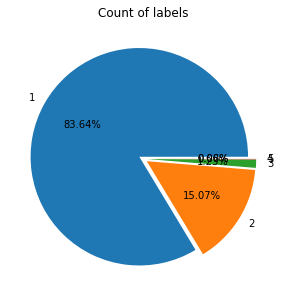

In [8]:
stats_df = pd.DataFrame(data = {
    'actual_count': df['emotions'].apply(len).value_counts(),
    'percentage': round(df['emotions'].apply(len).value_counts()/df.shape[0]*100, 2)
})

print(stats_df)

plt.figure(figsize=(5,5))
plt.pie(x=stats_df['actual_count'], 
        autopct='%.2f%%', 
        explode=[0.04]*stats_df.shape[0], 
        labels=stats_df.index)
plt.title('Count of labels')

Mapping the emotions using enkman mapping, the various emotions that are detected are decreased from 27 to 6, plus neutral.  
Given this, we find that 91% of the reddit post have one emotion and the rest 2 or more. 

   actual_count  percentage
1         39555       91.12
2          3763        8.67
3            92        0.21


Text(0.5, 1.0, 'Count of labels')

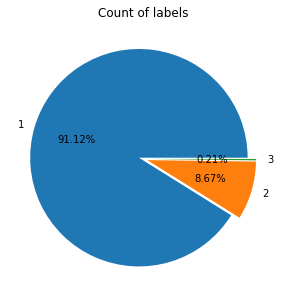

In [9]:
stats_df = pd.DataFrame(data = {
    'actual_count': df['mapped_emotions'].apply(len).value_counts(),
    'percentage': round(df['mapped_emotions'].apply(len).value_counts()/df.shape[0]*100, 2)
})

print(stats_df)

plt.figure(figsize=(5,5))
plt.pie(x=stats_df['actual_count'], 
        autopct='%.2f%%', 
        explode=[0.04]*stats_df.shape[0], 
        labels=stats_df.index)
plt.title('Count of labels')

In [25]:
df['mapped_emotions'].astype(str).value_counts()[:10]

['joy']                15216
['neutral']            12823
['anger']               4293
['surprise']            3858
['sadness']             2326
['surprise', 'joy']      775
['neutral', 'joy']       593
['fear']                 541
['disgust']              498
['sadness', 'joy']       318
Name: mapped_emotions, dtype: int64

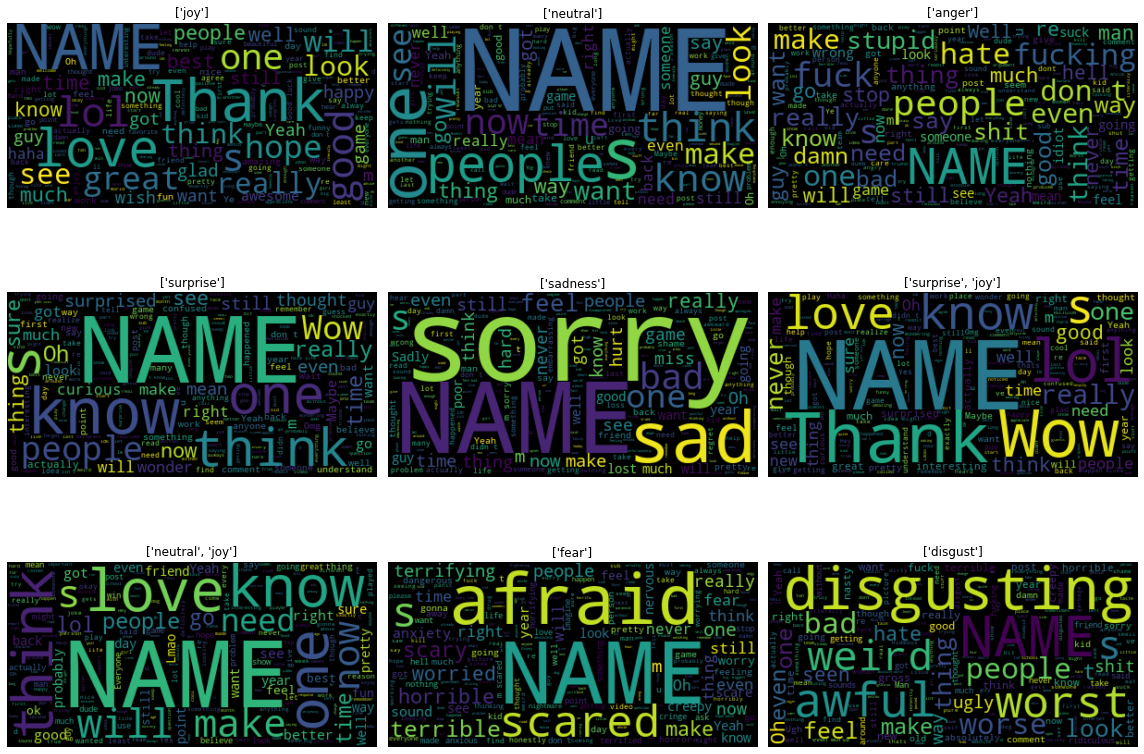

In [26]:
emotion_list = ["['joy']", "['neutral']", "['anger']", "['surprise']", "['sadness']", 
                "['surprise', 'joy']", "['neutral', 'joy']", "['fear']", "['disgust']"]


plt.figure(figsize=(16, 12))
for i, multi_emotion in enumerate(emotion_list):
    txt = df.loc[df['mapped_emotions'].astype(str)==multi_emotion, 'comment']

    plt.subplot(3,3,i+1)
    wordcloud = WordCloud().generate(' '.join(txt))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(multi_emotion)
    plt.axis("off")
plt.tight_layout()
plt.show()